<a href="https://colab.research.google.com/github/anomaitech/GeoApp/blob/main/pysheds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysheds


In [2]:
import rasterio
from pysheds.grid import Grid
from rasterio.plot import show
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

In [111]:
downscale_factor = 20

with rasterio.open('/content/elevation.tiff') as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height / downscale_factor),
            int(dataset.width / downscale_factor)
        ),
        out_dtype='float64'
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    profile = dataset.profile
    profile['nodata'] = '0'
    profile['dtype'] = 'float64'
    profile['transform'] = transform
    profile['width'] = int(dataset.width / downscale_factor)
    profile['height'] = int(dataset.height / downscale_factor)

In [112]:
with rasterio.open('/content/dtm_10.tif', 'w', **profile) as dst:
    dst.write(np.squeeze(data), 1)

In [113]:
dataset = rasterio.open('/content/dtm_10.tif')


In [114]:
dataset.transform, dataset.nodata


(Affine(0.016666666666666, 0.0, -100.0,
        0.0, -0.016666666666666, 34.9999999999998),
 0.0)

In [115]:
dtm_10 = dataset.read(1)

<Axes: >

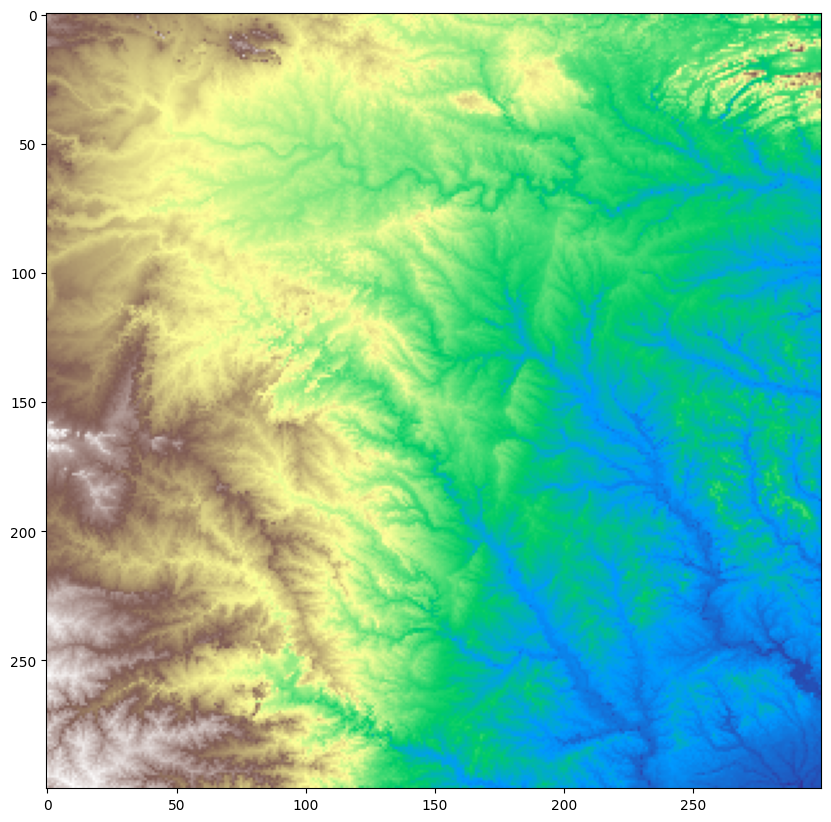

In [116]:

fig, ax = pyplot.subplots(1, 1, figsize=(10,18))
show(dtm_10, cmap='terrain', ax=ax)

In [117]:
grid = Grid.from_raster('/content/dtm_10.tif')
dem = grid.read_raster('/content/dtm_10.tif')

In [ ]:
grid

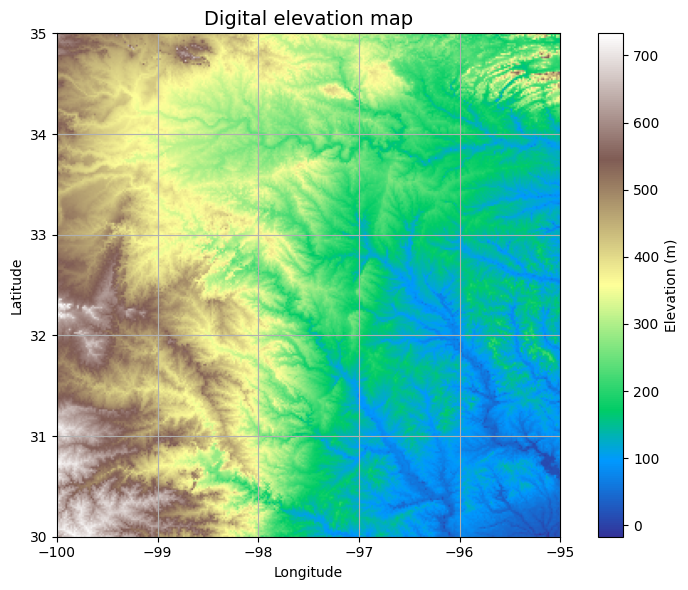

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [119]:
grid.nodata=np.int64(-9999.0)
dem.nodata=np.int64(-9999.0)


In [120]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [121]:
dem.dtype

dtype('float64')

In [122]:
pit_filled_dem = grid.fill_pits(dem,nodata_out=np.float64(-9999.0))

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [123]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=np.int64(-9999))

In [127]:
dem

Raster([[593., 607., 574., ..., 187., 175., 173.],
        [620., 603., 594., ..., 318., 298., 249.],
        [609., 605., 574., ..., 293., 266., 229.],
        ...,
        [666., 654., 682., ...,  15.,  23.,  23.],
        [694., 660., 646., ...,  19.,  22.,  22.],
        [661., 620., 633., ...,  15.,  18.,  17.]])

In [125]:
acc = grid.accumulation(fdir.astype(float), dirmap=dirmap,nodata_out=np.float64(-9999.0))


Number of cells with accumulation above 1000: 1865


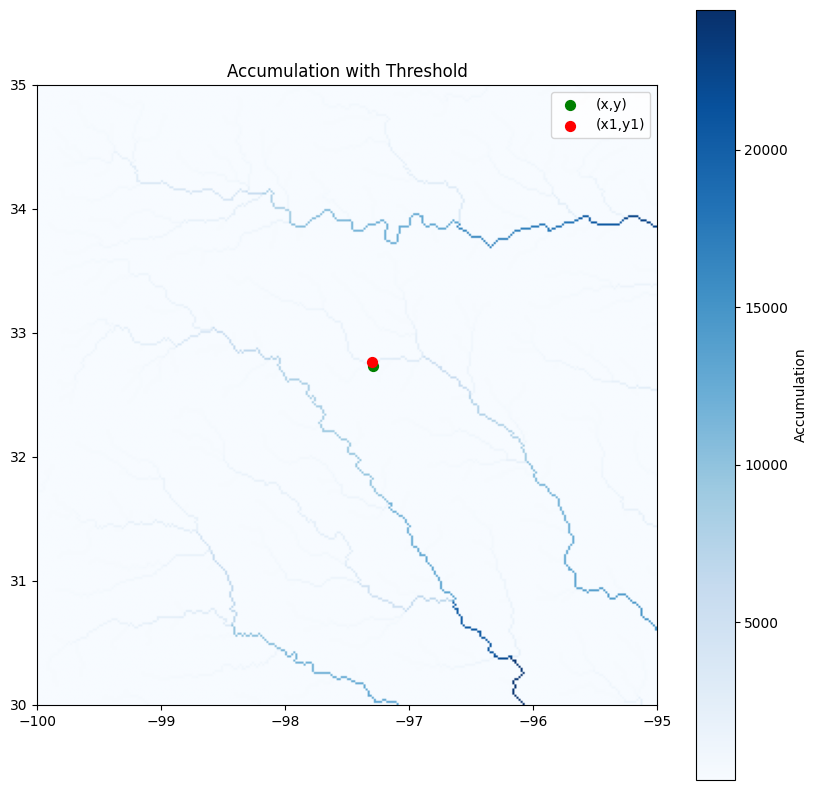

In [170]:

# Set a threshold for accumulation
threshold = 1000

# Find cells where accumulation exceeds the threshold
high_acc_cells = np.where(acc >= threshold)

# Get the coordinates of these cells
row_coords, col_coords = high_acc_cells

# Print coordinates or further process them as needed
print(f"Number of cells with accumulation above {threshold}: {len(row_coords)}")


# Visualization (optional):
fig, ax = plt.subplots(figsize=(10, 10))

# Display the accumulation
im = ax.imshow(acc,extent=grid.extent, cmap='Blues')

# Highlight cells above the threshold
x, y = -97.294, 32.737
x1,y1=-97.30000000000011,32.76666666666656

ax.scatter(x,y, color='green', s=50, label='(x,y)')
ax.scatter(x1,y1, color='red', s=50, label='(x1,y1)')
plt.colorbar(im, ax=ax, label='Accumulation')
ax.set_title('Accumulation with Threshold')
ax.legend()

plt.show()


In [146]:
from pysheds.view import View ,Raster

In [173]:
from pysheds.view import View, Raster
import numpy as np

def snap_to_mask(mask, xy, grid, return_dist=False, **kwargs):
    """
    Same docstring as above...
    """
    # Store original viewfinder nodata to restore later
    original_nodata = grid.viewfinder.nodata

    # If mask is not a Raster instance, create one
    if not isinstance(mask, Raster):
        if isinstance(mask, np.ndarray) and mask.dtype == np.bool_:
            nodata = False
            # Temporarily set viewfinder.nodata to False for boolean arrays
            grid.viewfinder.nodata = nodata
        else:
            nodata = -9999  # Adjust based on your data
        mask = Raster(mask, viewfinder=grid.viewfinder, metadata={'nodata': nodata})

    # Ensure mask is boolean and aligned with the grid
    mask_overrides = {'dtype': np.bool_, 'nodata': False}
    kwargs.update(mask_overrides)

    # Process mask using the grid's _input_handler


    # Get the affine transformation from the processed mask
    affine = mask.affine

    # Perform snapping using View.snap_to_mask
    result = View.snap_to_mask(mask, xy, affine=affine, return_dist=return_dist)

    # Restore original viewfinder nodata
    grid.viewfinder.nodata = original_nodata

    return result
x_snap, y_snap = snap_to_mask(acc > 1000, (x, y),grid)

-97.30000000000011 32.76666666666656


In [187]:
import numpy as np

def input_handler(fdir, **kwargs):
    # Replicate or wrap the functionality of self._input_handler from the class.
    # This might include reading metadata from fdir and applying kwargs.
    # For example, ensure that the fdir array is cast to the right dtype:
    dtype = kwargs.get('dtype', fdir.dtype)
    nodata = kwargs.get('nodata', getattr(fdir, 'nodata', None))
    # This is a placeholder – replace with the actual logic.
    fdir = fdir.astype(dtype)
    fdir.nodata = nodata
    return fdir

def d8_catchment(x, y, fdir, pour_value, dirmap, nodata_out, xytype, snap, algorithm):
    # Replace with the implementation of _d8_catchment
    # This is a placeholder that you must fill in with the actual algorithm.
    # For now, we’ll just return a dummy array.
    return np.array([[True]])

def dinf_catchment(x, y, fdir, pour_value, dirmap, nodata_out, xytype, snap, algorithm):
    # Replace with the implementation of _dinf_catchment
    return np.array([[True]])

def mfd_catchment(x, y, fdir, pour_value, dirmap, nodata_out, xytype, snap, algorithm):
    # Replace with the implementation of _mfd_catchment
    return np.array([[True]])

def catchment(x, y, fdir, pour_value=None,
              dirmap=(64, 128, 1, 2, 4, 8, 16, 32),
              nodata_out=False, xytype='coordinate', routing='d8',
              snap='corner', algorithm='iterative', **kwargs):
    """
    Standalone function to delineate a watershed from a pour point.
    """

    # Set up input overrides based on routing method
    if routing.lower() == 'd8':
        input_overrides = {'dtype': np.int64, 'nodata': getattr(fdir, 'nodata', None)}
    elif routing.lower() in {'dinf', 'mfd'}:
        input_overrides = {'dtype': np.float64, 'nodata': getattr(fdir, 'nodata', None)}
    else:
        raise ValueError('Routing method must be one of: `d8`, `dinf`, `mfd`')

    kwargs.update(input_overrides)
    fdir = input_handler(fdir, **kwargs)

    # Assuming fdir has a bbox attribute (xmin, ymin, xmax, ymax)
    xmin, ymin, xmax, ymax = fdir.bbox

    if xytype in {'label', 'coordinate'}:
        if (x < xmin) or (x > xmax) or (y < ymin) or (y > ymax):
            raise ValueError('Pour point ({}, {}) is out of bounds for dataset with bbox {}.'
                             .format(x, y, (xmin, ymin, xmax, ymax)))
    elif xytype == 'index':
        if (x < 0) or (y < 0) or (x >= fdir.shape[-1]) or (y >= fdir.shape[-2]):
            raise ValueError('Pour point ({}, {}) is out of bounds for dataset with shape {}.'
                             .format(x, y, fdir.shape))

    # Call the appropriate catchment routine
    if routing.lower() == 'd8':
        catch = d8_catchment(x, y, fdir=fdir, pour_value=pour_value, dirmap=dirmap,
                             nodata_out=nodata_out, xytype=xytype, snap=snap,
                             algorithm=algorithm)
    elif routing.lower() == 'dinf':
        catch = dinf_catchment(x, y, fdir=fdir, pour_value=pour_value, dirmap=dirmap,
                               nodata_out=nodata_out, xytype=xytype, snap=snap,
                               algorithm=algorithm)
    elif routing.lower() == 'mfd':
        catch = mfd_catchment(x, y, fdir=fdir, pour_value=pour_value, dirmap=dirmap,
                               nodata_out=nodata_out, xytype=xytype, snap=snap,
                               algorithm=algorithm)

    return catch


In [186]:
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

(0.0, 0.0, 100.0, 100.0)

In [ ]:
grid.clip_to(catch)
clipped_catch = grid.view(catch)

In [ ]:
fig, ax = pyplot.subplots(figsize=(16,12))
fig.patch.set_alpha(0)

pyplot.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
pyplot.title('Delineated Catchment', size=14)

In [174]:
import inspect
print(inspect.getsource(grid.catchment))


    def catchment(self, x, y, fdir, pour_value=None, dirmap=(64, 128, 1, 2, 4, 8, 16, 32),
                  nodata_out=False, xytype='coordinate', routing='d8', snap='corner',
                  algorithm='iterative', **kwargs):
        """
        Delineates a watershed from a given pour point (x, y).

        Parameters
        ----------
        x : float or int
            x coordinate (or index) of pour point
        y : float or int
            y coordinate (or index) of pour point
        fdir : Raster
               Flow direction data.
        pour_value : int or None
                     If not None, value to represent pour point in catchment
                     grid.
        dirmap : list or tuple (length 8)
                 List of integer values representing the following
                 cardinal and intercardinal directions (in order):
                 [N, NE, E, SE, S, SW, W, NW]
        nodata_out : int or float
                     Value to indicate `no data` in outp

In [155]:
acc.dtype

dtype('float64')

In [137]:
if mask.dtype == np.bool_:
    nodata = False
else:
    nodata = -9999

In [156]:
print(inspect.getsource(grid.))

TypeError: `nodata` value not representable in dtype of array.

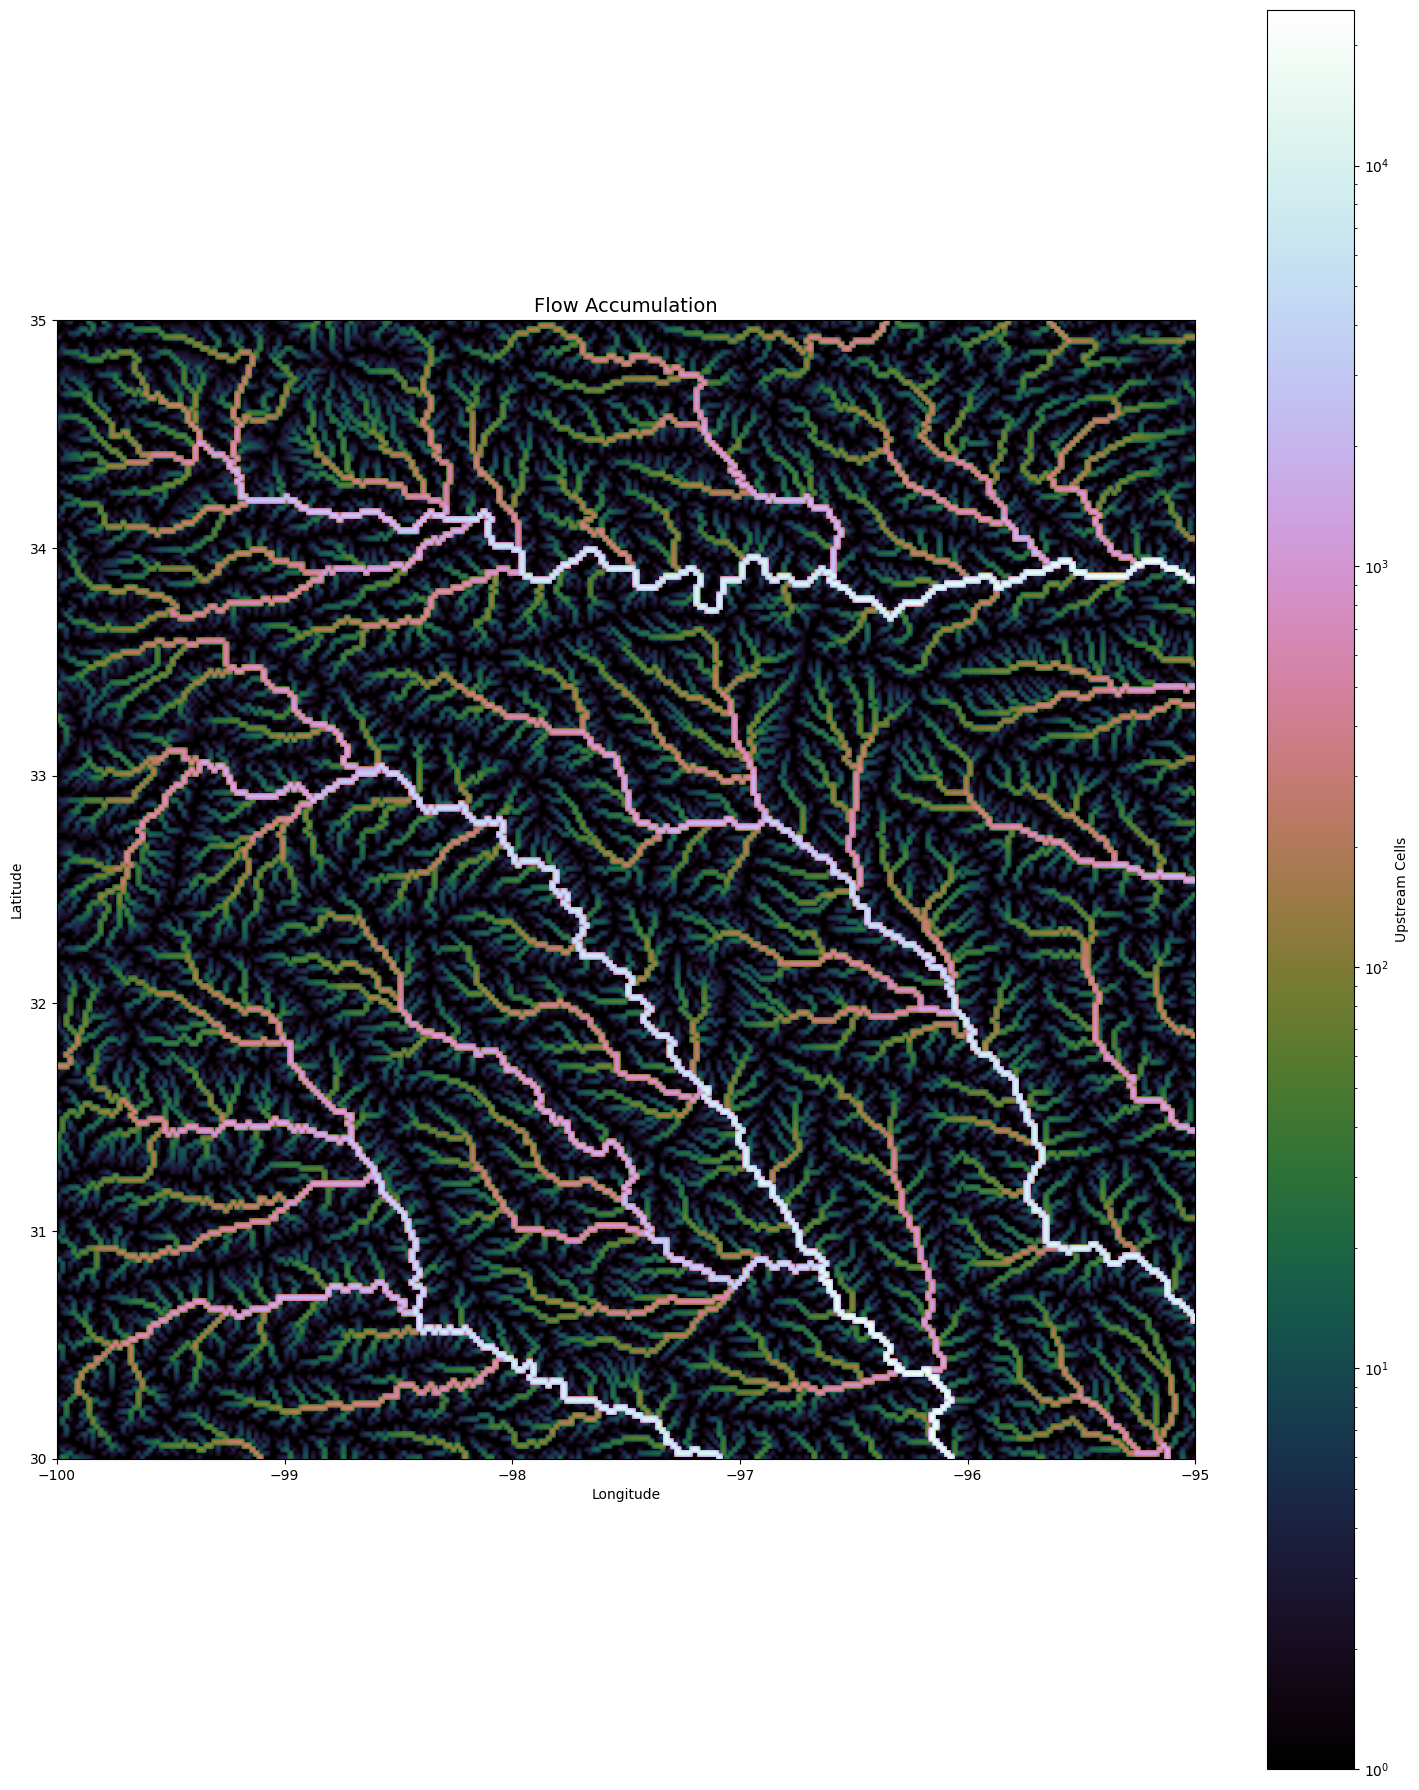

In [84]:
fig, ax = pyplot.subplots(figsize=(15,18))
fig.patch.set_alpha(0)
pyplot.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
pyplot.colorbar(im, ax=ax, label='Upstream Cells')
pyplot.title('Flow Accumulation', size=14)
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
pyplot.tight_layout()

In [ ]:
x, y = 321143, 7397199

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

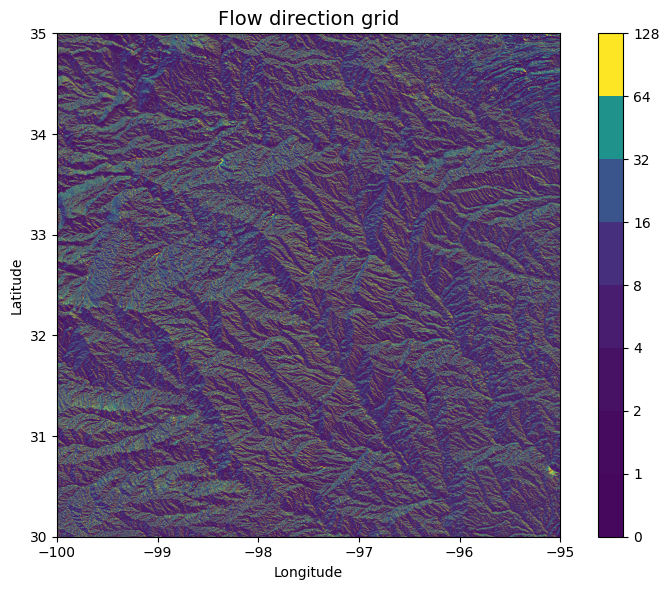

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
import numpy as np

# Use numpy types for nodata values, ensuring they are 64-bit
dem.nodata = np.int64(-9999)
grid.nodata = np.int64(-9999)

# Calculate flow direction with explicit 64-bit type handling
fdir = grid.flowdir(
    inflated_dem,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Must match array dtype
    dtype=np.int64  # Explicitly set output type to 64-bit
)

# Calculate accumulation with matching 64-bit types
acc = grid.accumulation(
    fdir,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Specify nodata_out with the correct type
    dtype=np.int64  # Must match flowdir's data type, use 64-bit
)


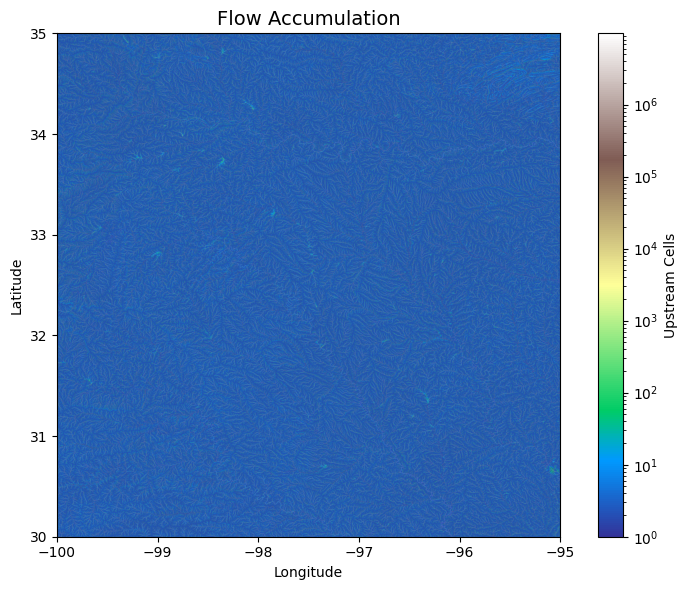

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)

# Try different colormaps, e.g., 'terrain', 'viridis', 'plasma', 'inferno'
cmap = 'terrain'

# Adjust normalization for better visualization
# You can try different vmin and vmax values or use a different normalization method like PowerNorm
norm = colors.LogNorm(vmin=1, vmax=acc.max())

im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap=cmap,
    norm=norm,
    interpolation='bilinear'
)

plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
x, y = -97.294, 32.737

def get_nodata(dtype):
    """Determine appropriate nodata value based on dtype."""
    if np.issubdtype(dtype, np.floating):
        return np.nan
    else:
        # For integer types, check if -9999 is valid, else use min/max
        if np.issubdtype(dtype, np.signedinteger):
            info = np.iinfo(dtype)
            return -9999 if info.min <= -9999 <= info.max else info.min
        else:  # Unsigned integer
            return np.iinfo(dtype).max

# Set nodata for accumulation grid (assuming `acc` is a numpy array)
acc.nodata = get_nodata(acc.dtype)

# Set nodata for sGrid using its underlying data (e.g., flow direction grid)
# Assuming `fdir` is the numpy array behind the `sGrid`
grid.nodata = get_nodata(fdir.dtype)  # Use dtype of the flow direction grid

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

TypeError: `nodata` value not representable in dtype of array.